In [1]:
%reset -f

In [2]:
import cobra as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import copy as cp
from IPython.display import clear_output

In [3]:
# Load Models

m1 = cb.io.load_matlab_model('/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_A_C/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_D_F/Eubacterium_hallii_DSM_3353.mat')

M = [m1, m2]


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-17


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [4]:
# Define Media

# AGORA Format
media = {
    'EX_o2(e)': 0, #aerobic/anaerobic
    'EX_h2o(e)': -1000,
    'EX_pi(e)': -1000,
    'EX_fe2(e)': -1000,
    'EX_fe3(e)': -1000,
    'EX_zn2(e)': -1000,
    'EX_so4(e)': -1000,
    'EX_cu2(e)': -1000,
    'EX_k(e)': -1000,
    'EX_mg2(e)': -1000,
    'EX_mn2(e)': -1000,
    'EX_cd2(e)': -1000,
    'EX_cl(e)': -1000,
    'EX_ca2(e)': -1000,
    'EX_cobalt2(e)': -1000,
    'EX_glc_D(e)': -10,
    'EX_nh4(e)': -20,

    'EX_ribflv(e)': -1000,
    'EX_pnto_R(e)': -1000,
    'EX_nac(e)': -1000,
    'EX_his_L(e)': -1000,
    'EX_asn_L(e)': -1000,
    'EX_glycys(e)': -1000,

    'EX_lys_L(e)': -1000,
    'EX_ala_L(e)': -1000,
    'EX_met_L(e)': -1000,
    'EX_leu_L(e)': -1000,
    'EX_hxan(e)': -1000,    
    'EX_ser_L(e)': -1,
}

In [5]:
# Dynamic Simulation (run through 1 time step split int m_n substeps)
def dynamic_simulation(m_n, m_f, models, ra, media, EX):
    # count total unique exchange reactions in all models
    N = len(EX)
    dxdt = np.zeros(N)

    results = np.zeros((N, m_n, len(models)))
    sum_results = np.zeros((N,len(models)))
    xs = np.zeros((N, m_n))

    # initialize state vector
    x = np.zeros(N)
    # update media with media fluxes
    dxdt = np.zeros(N)
    for e, flux in media.items():
        ind = EX.index(e)
        dxdt[ind] = -1*flux
    # update state vector with media fluxes
    x = x + dxdt

    # update media with model fluxes
    # loop m_n times to smooth dynamics
    for m_i in range(m_n):
        clear_output(wait=False)
        print('Step ' + str(m_i) + ' of ' + str(m_n))

        xs[:,m_i] = x #keep track of state vector over time

        x_tmp = x
        for i in range(len(models)):
            dxdt = np.zeros(N)

            m = models[i]
            ra_i = ra[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of x available to be fluxed
                    flux_lim = x[ind]/ra_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            sol = m.optimize()

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol.fluxes[exch.id]
                ind = EX.index(e)
                dxdt[ind] = (flux*ra_i)*m_f

                results[ind,m_i,i] = flux
                sum_results[ind,i] = sum_results[ind,i] + dxdt[ind]

            # update state vector with model fluxes
            x_tmp = x_tmp + dxdt
        
        x = x_tmp

    return results, sum_results, xs

In [6]:
# Simulation
ra = [0.5, 0.5]
m_n = 1000
m_f = 0.01

EX = []
for m in M:
    for exch in m.exchanges:
        EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N = len(EX)
x0 = np.zeros(N)

models = cp.deepcopy(M)

Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmp3z791yct.lp
Reading time = 0.01 seconds
: 932 rows, 2064 columns, 8440 nonzeros
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmp3lomlcgl.lp
Reading time = 0.01 seconds
: 980 rows, 2102 columns, 8980 nonzeros


In [7]:
results, sum_results, xs = dynamic_simulation(m_n, m_f, models, ra, media, EX)

Step 999 of 1000


[1.00000000e+01 9.80000000e+00 9.60400000e+00 9.41192000e+00
 9.22368160e+00 9.03920797e+00 8.85842381e+00 8.68125533e+00
 8.50763023e+00 8.33747762e+00 8.17072807e+00 8.00731351e+00
 7.84716724e+00 7.69022389e+00 7.53641941e+00 7.38569103e+00
 7.23797721e+00 7.09321766e+00 6.95135331e+00 6.81232624e+00
 6.67607972e+00 6.54255812e+00 6.41170696e+00 6.28347282e+00
 6.15780337e+00 6.03464730e+00 5.91395435e+00 5.79567526e+00
 5.67976176e+00 5.56616652e+00 5.45484319e+00 5.34574633e+00
 5.23883140e+00 5.13405478e+00 5.03137368e+00 4.93074621e+00
 4.83213128e+00 4.73548866e+00 4.64077888e+00 4.54796331e+00
 4.45700404e+00 4.36786396e+00 4.28050668e+00 4.19489655e+00
 4.11099862e+00 4.02877864e+00 3.94820307e+00 3.86923901e+00
 3.79185423e+00 3.71601714e+00 3.64169680e+00 3.56886286e+00
 3.49748561e+00 3.42753590e+00 3.35898518e+00 3.29180547e+00
 3.22596936e+00 3.16144998e+00 3.09822098e+00 3.03625656e+00
 2.97553143e+00 2.91602080e+00 2.85770038e+00 2.80054637e+00
 2.74453545e+00 2.689644

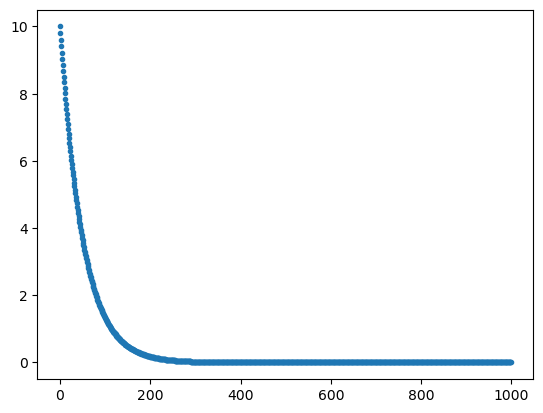

In [8]:
i = EX.index('EX_glc_D(e)')
print(xs[i,:])
print(results[i,:,:])
print(sum_results[i,:])
plt.plot(xs[i],'.')

[0.00000000e+00 1.75078116e-01 3.45976500e-01 5.12786472e-01
 6.75597338e-01 8.34496436e-01 9.89569178e-01 1.14089909e+00
 1.28829684e+00 1.43104651e+00 1.56925806e+00 1.70303907e+00
 1.83249481e+00 1.95772827e+00 2.07884021e+00 2.19592923e+00
 2.30909178e+00 2.41842223e+00 2.52401291e+00 2.62595411e+00
 2.72433422e+00 2.81923965e+00 2.91075497e+00 2.99896289e+00
 3.08394431e+00 3.16577838e+00 3.24454252e+00 3.32031244e+00
 3.39316222e+00 3.46316429e+00 3.53038950e+00 3.59490716e+00
 3.65678502e+00 3.71608938e+00 3.77288505e+00 3.82723543e+00
 3.87920249e+00 3.92884688e+00 3.97622785e+00 4.02140338e+00
 4.06443014e+00 4.10536355e+00 4.14425780e+00 4.18116587e+00
 4.21613955e+00 4.24922949e+00 4.28048518e+00 4.30995504e+00
 4.33768638e+00 4.36372544e+00 4.38811745e+00 4.41090660e+00
 4.43213608e+00 4.45184811e+00 4.47008397e+00 4.48688398e+00
 4.50228757e+00 4.51633325e+00 4.52905868e+00 4.54050063e+00
 4.55069507e+00 4.55967711e+00 4.56748108e+00 4.57414051e+00
 4.57968818e+00 4.584156

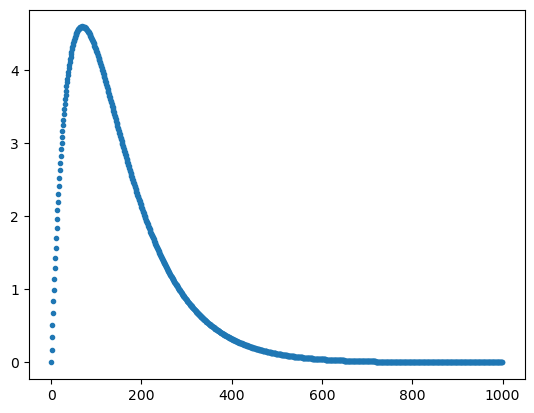

In [9]:
i = EX.index('EX_lac_L(e)')
print(xs[i,:])
print(results[i,:,:])
print(sum_results[i,:])
plt.plot(xs[i],'.')

[0.         0.04876262 0.09697465 0.14464717 0.191791   0.23841678
 0.28453491 0.33015562 0.37528892 0.41994351 0.46412475 0.50783792
 0.55108823 0.59388083 0.637435   0.68188092 0.72718313 0.77330707
 0.82021902 0.86788611 0.91627633 0.96535844 1.01510202 1.0654774
 1.11645568 1.16800872 1.22010906 1.27273    1.32584548 1.37943016
 1.43345934 1.48790898 1.54275564 1.59797655 1.65354949 1.70945288
 1.76566569 1.82216745 1.87893827 1.93595876 1.99321009 2.05067394
 2.10833248 2.16616838 2.22416479 2.28230533 2.34057408 2.39895557
 2.45743477 2.51599707 2.57455851 2.63253884 2.6899438  2.74677907
 2.80305026 2.85876293 2.91392259 2.9685347  3.02260466 3.07613781
 3.12913946 3.18161485 3.23356917 3.28500757 3.33593514 3.38635693
 3.43627792 3.48570308 3.53463728 3.5830854  3.63105221 3.67854249
 3.72556094 3.77211223 3.81820097 3.86383173 3.90900905 3.9537374
 3.99802122 4.04186492 4.08527285 4.12824931 4.17079857 4.21292487
 4.25463238 4.29592525 4.33680759 4.37728345 4.41735687 4.457031

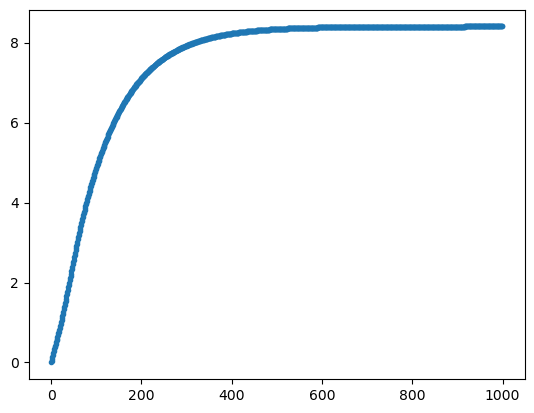

In [10]:
i = EX.index('EX_but(e)')
print(xs[i,:])
print(results[i,:,:])
print(sum_results[i,:])
plt.plot(xs[i],'.')

[0.00000000e+00 7.13441227e-02 1.41324827e-01 2.09962102e-01
 2.77275679e-01 3.43285033e-01 4.08009384e-01 4.71467702e-01
 5.33859332e-01 5.95734620e-01 6.57096576e-01 7.17948225e-01
 7.78292604e-01 8.38132760e-01 8.95043399e-01 9.48777256e-01
 9.99418263e-01 1.04704847e+00 1.09174808e+00 1.13359550e+00
 1.17266737e+00 1.20903859e+00 1.24278237e+00 1.27397029e+00
 1.30267227e+00 1.32895666e+00 1.35289027e+00 1.37453837e+00
 1.39396474e+00 1.41123173e+00 1.42640024e+00 1.43952977e+00
 1.45067848e+00 1.45990317e+00 1.46725934e+00 1.47280122e+00
 1.47658177e+00 1.47865273e+00 1.47906465e+00 1.47786689e+00
 1.47510766e+00 1.47083407e+00 1.46509210e+00 1.45792666e+00
 1.44938163e+00 1.43949983e+00 1.42832308e+00 1.41589222e+00
 1.40224711e+00 1.38742668e+00 1.37161121e+00 1.35599271e+00
 1.34056843e+00 1.32533566e+00 1.31029176e+00 1.29543409e+00
 1.28076008e+00 1.26626719e+00 1.25195292e+00 1.23781482e+00
 1.22385046e+00 1.21005745e+00 1.19643345e+00 1.18297615e+00
 1.16968327e+00 1.156552

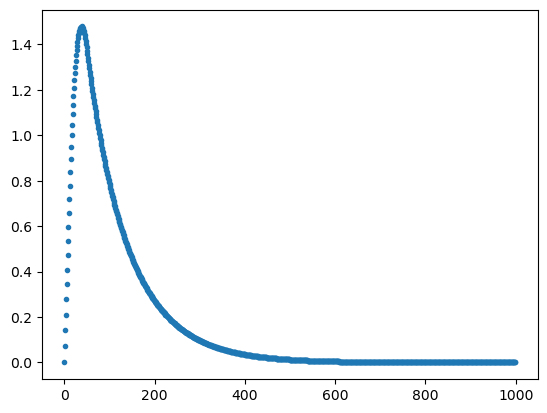

In [13]:
i = EX.index('EX_ac(e)')
print(xs[i,:])
print(results[i,:,:])
print(sum_results[i,:])
plt.plot(xs[i],'.')

In [25]:
df = pd.DataFrame(sum_results, index=EX)
tol = 1e-9
nonzero_rows = df[(df.abs() > tol).any(axis=1)]
print(nonzero_rows)

                      0          1
EX_ac(e)      -0.241277   0.241361
EX_asn_L(e)   -0.014503  -0.069234
EX_biomass(e)  0.061798   0.295012
EX_ca2(e)     -0.000483  -0.002304
EX_cl(e)      -0.000483  -0.002304
EX_co2(e)      0.409777  17.435447
EX_cobalt2(e) -0.000483  -0.002304
EX_cu2(e)     -0.000483  -0.002304
EX_etoh(e)     0.251709   0.000000
EX_fe2(e)     -0.000483  -0.002304
EX_fe3(e)     -0.000483  -0.002304
EX_for(e)     -0.007816   0.013823
EX_glc_D(e)   -5.000000  -5.000000
EX_glycys(e)  -0.016175  -0.030858
EX_h(e)        9.239514  -6.268483
EX_h2o(e)      1.485937   5.801999
EX_his_L(e)   -0.005724   0.109512
EX_hxan(e)    -0.027299  -0.134927
EX_k(e)       -0.000483  -0.002304
EX_lac_L(e)    9.124742  -9.123952
EX_leu_L(e)   -0.027108  -0.129410
EX_met_L(e)    0.000000  -0.046361
EX_mg2(e)     -0.000483  -0.002304
EX_mn2(e)     -0.000483  -0.002304
EX_nac(e)     -0.000965  -0.004608
EX_nh4(e)     -0.465597  -1.164539
EX_pi(e)      -0.091465  -0.423214
EX_pnto_R(e)  -0.000